In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

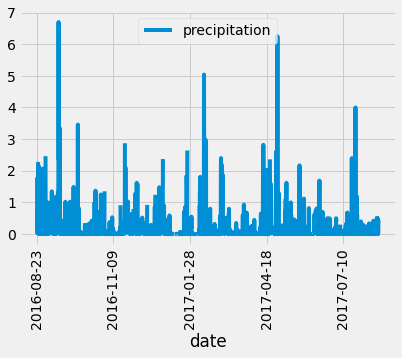

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
# print(df.to_string(index=False))

# Sort the dataframe by date
df = df.sort_index()
# print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data

df.plot()
plt.xticks(rotation=90)


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# What are the most active stations?
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station)

# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

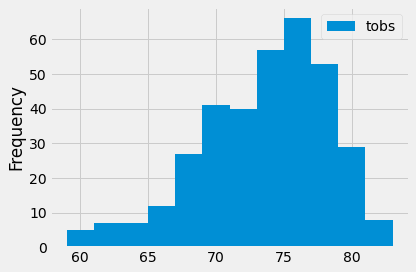

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.tobs)
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()


In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return c_results
calc_temps('2017-01-01', '2017-12-31')

[(58.0, 74.14387974230493, 87.0)]

In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-07-02', '2017-07-08')
trip_results

[(71.0, 78.11904761904762, 87.0)]

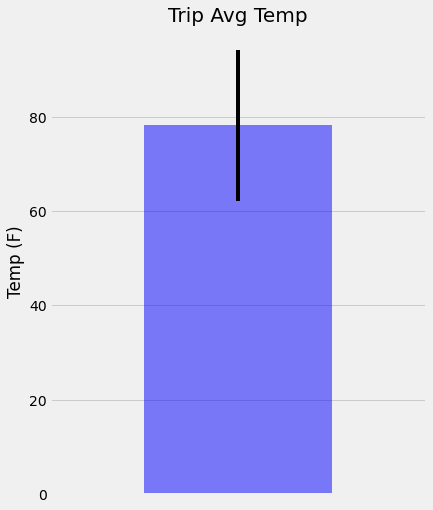

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='blue', grid = False)
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

# Challenge